# Installing the required libraries

In [ ]:
!pip install "gymnasium[atari]" > /dev/null
!pip install autorom[accept-rom-license] > /dev/null
!pip install torch > /dev/null
!pip install moviepy > /dev/null
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null

# Import libraries

In [ ]:
# Working with the operating system: creating, deleting, checking the existence of directories and files
import os

# Image and video processing. Used to preprocess observations from the Atari environment
import cv2

# Random number generation. Used to implement a random strategy (Random Policy)
import random

# Working with multidimensional arrays and mathematical operations on them
import numpy as np

# PyTorch library for building and training neural networks
import torch
import torch.nn as nn # for creating neural network layers and models
import torch.optim as optim # optimizer for updating neural network weights

# Encoding data in Base64 format. Used to convert a video file to a string for display in HTML
from base64 import b64encode

# Displaying HTML content in Jupyter/Colab notebooks
from IPython.display import HTML

# For Atari games, it is better to use the gymnasium fork, it is more stable and has no dependency issues
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

# Library for working with classic Atari games. It is used to interact with the ALE (Arcade Learning Environment) emulator
import ale_py

# Registering the environment
gym.register_envs(ale_py)

# Working with graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Disabling unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

# Checking the environment

In [ ]:
env = gym.make("ALE/Alien-v5", render_mode='rgb_array')
print(type(env))

<class 'gymnasium.wrappers.common.OrderEnforcing'>


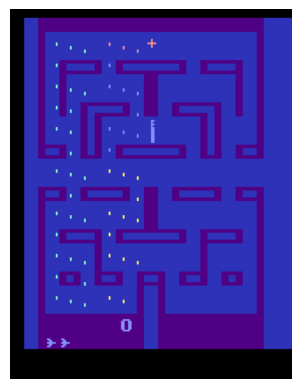

In [ ]:
# Reset the environment to its initial state before starting
env.reset()

# Draw the initial game state
prev_screen = env.render()
plt.imshow(prev_screen)
plt.axis('off') # Hide the axes
plt.show()

# Helper functions

Preprocessing:

In [ ]:
def preprocess(obs):
    # Convert to grayscale and resize
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY) # (210, 160) after
    obs = cv2.resize(obs, (84, 84)) # (84, 84)

    # Convert to flat array and normalize
    obs = obs.flatten()                          # (7056,)
    obs = obs / 255.0                            # [0..1]

    return obs

Video recording function:

In [ ]:
def record_video(env_id, model, out_directory, num_episodes=10):
    env = gym.make(env_id, render_mode='rgb_array')
    env = RecordVideo(env, video_folder=out_directory)
    for _ in range(num_episodes):
        obs, _ = env.reset()
        obs = preprocess(obs)
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            obs = preprocess(obs)
            done = terminated or truncated
    env.close()

# Implementation of a simple model

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),  # input_dim must be 7056
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

# Random Search Strategy (Random Policy)

In [ ]:
class RandomPolicy:
    def __init__(self, action_space):
        self.action_space = action_space

    def predict(self, observation):
        return self.action_space.sample(), None

Collecting reward data for a random strategy:

In [ ]:
def evaluate_random_policy(env_id, num_episodes=10):
    env = gym.make(env_id)
    rewards = []
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = random.choice(range(env.action_space.n))
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            done = terminated or truncated
        rewards.append(total_reward)
        print(f"Episode {episode + 1}, Reward: {total_reward}")
    env.close()
    return rewards

# Strategy Gradient Algorithm (Policy Gradient)

In [ ]:
class PGAgent:
    def __init__(self, input_dim, action_dim, lr=0.01, gamma=0.99):
        self.policy = PolicyNetwork(input_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma

    def select_action(self, state):
        state = torch.FloatTensor(state)
        probs = self.policy(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def predict(self, obs):
        with torch.no_grad():
            state = torch.FloatTensor(obs)
            probs = self.policy(state)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
        return action.item(), None

    def update_policy(self, rewards, log_probs):
        if not log_probs:
            print("No log probs. Skipping update.")
            return

        discounted_rewards = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            discounted_rewards.insert(0, R)
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-7)

        policy_loss = []
        for log_prob, reward in zip(log_probs, discounted_rewards):
            loss = -log_prob * reward
            policy_loss.append(loss.unsqueeze(0))

        policy_loss = torch.cat(policy_loss).sum()

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

# Training

In [ ]:
N_EPISODE = 100

In [ ]:
def train_pg_agent(env_id="ALE/Alien-v5", episodes=10):
    env = gym.make(env_id)
    input_dim = 84 * 84
    action_dim = env.action_space.n

    agent = PGAgent(input_dim, action_dim)
    all_rewards = []

    for episode in range(episodes):
        obs, _ = env.reset()
        obs = preprocess(obs)
        done = False
        total_reward = 0
        log_probs = []
        rewards = []

        while not done:
            action, log_prob = agent.select_action(obs)
            next_obs, reward, done, _, _ = env.step(action)
            next_obs = preprocess(next_obs)

            log_probs.append(log_prob)
            rewards.append(reward)
            total_reward += reward
            obs = next_obs

        agent.update_policy(rewards, log_probs)
        all_rewards.append(total_reward)
        print(f"Episode {episode + 1}, Reward: {total_reward}")

    env.close()
    return agent, all_rewards

In [ ]:
# Create a random search model
random_model = RandomPolicy(gym.make("ALE/Alien-v5").action_space)

In [ ]:
# Evaluating a random strategy
random_rewards = evaluate_random_policy("ALE/Alien-v5", num_episodes=N_EPISODE)

Episode 1, Reward: 240.0
Episode 2, Reward: 330.0
Episode 3, Reward: 290.0
Episode 4, Reward: 230.0
Episode 5, Reward: 300.0
Episode 6, Reward: 170.0
Episode 7, Reward: 150.0
Episode 8, Reward: 150.0
Episode 9, Reward: 250.0
Episode 10, Reward: 130.0
Episode 11, Reward: 140.0
Episode 12, Reward: 90.0
Episode 13, Reward: 110.0
Episode 14, Reward: 200.0
Episode 15, Reward: 130.0
Episode 16, Reward: 160.0
Episode 17, Reward: 240.0
Episode 18, Reward: 120.0
Episode 19, Reward: 310.0
Episode 20, Reward: 250.0
Episode 21, Reward: 260.0
Episode 22, Reward: 280.0
Episode 23, Reward: 160.0
Episode 24, Reward: 220.0
Episode 25, Reward: 140.0
Episode 26, Reward: 140.0
Episode 27, Reward: 190.0
Episode 28, Reward: 150.0
Episode 29, Reward: 200.0
Episode 30, Reward: 130.0
Episode 31, Reward: 190.0
Episode 32, Reward: 190.0
Episode 33, Reward: 230.0
Episode 34, Reward: 230.0
Episode 35, Reward: 170.0
Episode 36, Reward: 250.0
Episode 37, Reward: 160.0
Episode 38, Reward: 220.0
Episode 39, Reward: 18

In [ ]:
# Models
pg_model, pg_rewards = train_pg_agent(episodes=N_EPISODE) # we teach a little for demonstration

Episode 1, Reward: 210.0
Episode 2, Reward: 30.0
Episode 3, Reward: 100.0
Episode 4, Reward: 100.0
Episode 5, Reward: 100.0
Episode 6, Reward: 100.0
Episode 7, Reward: 100.0
Episode 8, Reward: 100.0
Episode 9, Reward: 100.0
Episode 10, Reward: 100.0
Episode 11, Reward: 100.0
Episode 12, Reward: 100.0
Episode 13, Reward: 100.0
Episode 14, Reward: 100.0
Episode 15, Reward: 100.0
Episode 16, Reward: 100.0
Episode 17, Reward: 100.0
Episode 18, Reward: 100.0
Episode 19, Reward: 100.0
Episode 20, Reward: 100.0
Episode 21, Reward: 100.0
Episode 22, Reward: 100.0
Episode 23, Reward: 100.0
Episode 24, Reward: 100.0
Episode 25, Reward: 100.0
Episode 26, Reward: 100.0
Episode 27, Reward: 100.0
Episode 28, Reward: 100.0
Episode 29, Reward: 100.0
Episode 30, Reward: 100.0
Episode 31, Reward: 100.0
Episode 32, Reward: 100.0
Episode 33, Reward: 100.0
Episode 34, Reward: 100.0
Episode 35, Reward: 100.0
Episode 36, Reward: 100.0
Episode 37, Reward: 100.0
Episode 38, Reward: 100.0
Episode 39, Reward: 10

Plotting the graph:

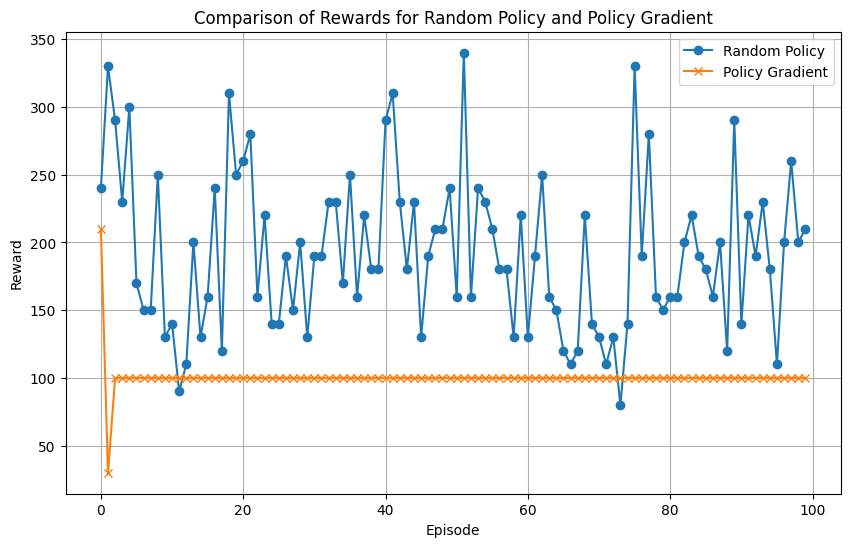

In [ ]:
# Visualizing Rewards
plt.figure(figsize=(10, 6))

# Random Strategy Rewards
plt.plot(random_rewards, label='Random Policy', marker='o')

# Policy Gradient Rewards
plt.plot(pg_rewards, label='Policy Gradient', marker='x')

# Plot Settings
plt.title('Comparison of Rewards for Random Policy and Policy Gradient')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()

Derivation of the average reward for each strategy:

In [ ]:
# Average reward for random policy
mean_random_reward = np.mean(random_rewards)
print(f"Mean Reward (Random Policy): {mean_random_reward:.2f}")

# Average reward for Policy Gradient
mean_pg_reward = np.mean(pg_rewards)
print(f"Mean Reward (Policy Gradient): {mean_pg_reward:.2f}")

Mean Reward (Random Policy): 192.40
Mean Reward (Policy Gradient): 100.40


# Video recording

In [ ]:
# Create folders for videos
os.makedirs("videos/random", exist_ok=True)
os.makedirs("videos/policy_gradient", exist_ok=True)

In [ ]:
# Recording video
record_video("ALE/Alien-v5", random_model, "videos/random")
record_video("ALE/Alien-v5", pg_model, "videos/policy_gradient")

# Video Analysis

In [ ]:
def show_video(path):
    # Check if the file exists
    if not os.path.exists(path):
    raise FileNotFoundError(f"File {path} not found.")

    # Open the video file
    with open(path, "rb") as f:
    video_data = f.read()

    # Create HTML code to play the video
    data_url = "data:video/mp4;base64," + b64encode(video_data).decode()
    return HTML(f'<video controls width="640" height="480"><source src="{data_url}" type="video/mp4"></video>')

In [ ]:
# Showing a video of a random agent
show_video("/content/videos/random/rl-video-episode-0.mp4")

In [ ]:
# Showing video Policy Gradient
show_video("/content/videos/policy_gradient/rl-video-episode-0.mp4")

Why is Policy Gradient worse?

Possible reasons:

* Not enough training data — Policy Gradient requires many episodes to learn stable policies.
* High reward variance — especially in Atari games where rewards are rare.
* No baseline — without it, Policy Gradient is very noisy.
* Too simple a model — we use a fully connected network, without CNN.
* Bad preprocessing — the image is simply scaled, there is no frame stacking, etc.

Conclusion:
Policy Gradient in its current implementation performs worse than random search because:
1. It does not cope well with sparse rewards.
2. It requires much more data to converge.
3. It does not use effective variance reduction methods (e.g. baseline or critic).
4. The model architecture is too simple for the complexity of Atari.